In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

from sigvisa import Sigvisa
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.signals.io import fetch_waveform
from sigvisa.source.event import Event

In [2]:
def setup_graph(sta="PD31"):
    stime = 1239041000 
    etime = 1239041400
    
    
    s = Sigvisa()
    cursor = s.dbconn.cursor()
    wave = fetch_waveform(sta, chan="auto", stime=stime, etime=etime, cursor=cursor)
    wave = wave.filter("freq_0.8_4.5;env;hz_2")
    
    sg = SigvisaGraph(template_model_type="param", template_shape="lin_polyexp",
                      wiggle_model_type="dummy", wiggle_family="iid", 
                      dummy_fallback=True, runids = (3,),
                      phases=["P", "S", "PcP", "ScP", "pP", "Pg", "Lg"], base_srate=2.0,
                      assume_envelopes=True, smoothing=None,
                      hack_param_constraint=True,
                      uatemplate_rate=1e-4)
    sg.add_wave(wave)
    
    vals2 = dict([('mult_wiggle_std', 0.46665908122829375), ('coda_decay', -3.8817786855627583), ('peak_offset', 1.8717964476973965), ('coda_height', 4.6420525405366337), ('arrival_time', 1239041071.3935068), ('peak_decay', -3.3833567577066019)])
    vals30 = dict([('mult_wiggle_std', 0.58921556906392525), ('coda_decay', -2.0648019615477597), ('peak_offset', 1.2059866915167161), ('coda_height', 4.9700447940413781), ('arrival_time', 1239041119.0734844), ('peak_decay', -1.8286789034181647)])
    wn = sg.station_waves.values()[0][0]
    sg.create_unassociated_template(wn, vals2['arrival_time'], tmid=2, initial_vals=vals2)
    sg.create_unassociated_template(wn, vals2['arrival_time'], tmid=30, initial_vals=vals30)
    return sg


In [3]:
sg = setup_graph()
ev = Event(lon=-105.427, lat=43.731, depth=0.0, time=1239041017.07, mb=4.0)


n_uatemplate: -18.5
n_event: -0.6
ev priors: ev 0.0
ev observations: ev 0.0
tt_residual: ev 0.0
ev global cost (n + priors + tt): -0.6
coda_decay: ev 0.0 ua -3.1 total -3.1
peak_decay: ev 0.0 ua -2.5 total -2.5
peak_offset: ev 0.0 ua -3.4 total -3.4
coda_height: ev 0.0 ua -6.1 total -6.1
mult_std_wiggle: ev 0.0 ua -0.3 total -0.3
coef jointgp: 0.0
total param: ev 0.0 ua -15.4 total -15.4
priors+params: ev -0.6 ua -33.9 total -34.4
station noise (observed signals): -1418.9
noise model prior lp: 7.2
overall: -1446.1
official: -1446.1
plotting uatemplate -2 as color (0.0, 0.0, 0.5, 1.0)
plotting uatemplate -30 as color (0.0, 0.0, 0.60695187165775399, 1.0)
reading station detections... 


/home/dmoore/python/sigvisa/models/signal_model.py:587: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


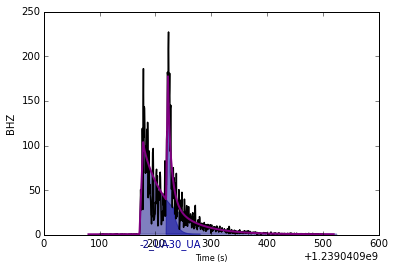

In [4]:
sg.current_log_p_breakdown()
wn = sg.station_waves.values()[0][0]
wn.plot(ax=plt.gca())

In [5]:
from collections import defaultdict
import itertools
from sigvisa.models.ttime import tt_predict
from sigvisa.infer.event_birthdeath import template_association_logodds, associate_template, unassociate_template
from sigvisa.utils.counter import Counter

def joint_association_distribution(sg, wn, eid, phases, ignore_mb=False, max_ttr=25.0):
    ev = sg.get_event(eid)
    possible_associations = defaultdict(list)
    
    for phase in phases:
        pred_atime = ev.time + tt_predict(ev, wn.sta, phase=phase)
        possible_associations[phase].append((None, sg.uatemplate_rate))
        for tmid in sg.uatemplate_ids[(wn.sta,wn.chan,wn.band)]:
            tmnodes = sg.uatemplates[tmid]
            atime = tmnodes['arrival_time'].get_value()
            if np.abs(atime - pred_atime) < max_ttr: 
                odds = np.exp(template_association_logodds(sg, wn, tmid, eid, phase, ignore_mb=ignore_mb))
                possible_associations[phase].append((tmid, odds))
                print "odds for", phase, tmid, "are", odds

    vals = [possible_associations[k] for k in phases]
    joint_dist = Counter()
    for assoc in itertools.product(*vals):
        tmids, odds = zip(*assoc)
        nontrivial_tmids = [t for t in tmids if t is not None]
        if len(set(nontrivial_tmids)) != len(nontrivial_tmids):
            # duplicate tmid, assigned to two phases
            continue
        joint_dist[tmids] = np.prod(odds)
    joint_dist.normalize()
    return joint_dist
    

ImportError: cannot import name template_association_logodds

In [151]:
from sigvisa.infer.event_birthdeath import smart_peak_time_proposal, heuristic_amplitude_posterior, ev_death_helper

def clean_propose_phase_template(sg, wn, eid, phase, 
                                 fix_result=None, 
                                 debug_info=None,
                                 ev=None):
    # add the given phase to the graph, with appropriate proposal values (or fix_result)
    # return the tmvals and stuff
    if ev is None:
        ev = sg.get_event(eid)
        

    # add the template
    
    #sg._topo_sort()
    
    # sample most of the template params from the event-conditional prior
    tmnodes = sg.get_template_nodes(eid, wn.sta, phase, wn.band, wn.chan)
    k_ttr, n_ttr = tmnodes["tt_residual"]
    k_time, n_time = tmnodes["arrival_time"]
    k_amp, n_amp = tmnodes["amp_transfer"]
    k_height, n_height = tmnodes["coda_height"]
    tmvals = {}
    log_q = 0.0
    for param, (k, n) in tmnodes.items():
        if param in ("tt_residual", "amp_transfer") or n.deterministic():
            continue
        if fix_result is not None:
            n.set_value(fix_result[param])
        else:
            n.parent_sample()
        param_lp = n.log_p()
        log_q += param_lp
        
        tmvals[param] = n.get_value()
        if debug_info is not None:
            debug_info[param] = (tmvals[param], param_lp, param_lp)
        print "param", param, "val", tmvals[param], "lp", param_lp
        
    # then sample atime from the signal
    pred_atime = ev.time + tt_predict(ev, wn.sta, phase)
    debug_lps = {}
    if fix_result is not None:
        tmvals["arrival_time"] = fix_result["arrival_time"]
    peak_lp = smart_peak_time_proposal(sg, wn, tmvals, eid, phase,
                                       pred_atime,
                                       use_correlation=False,
                                       prebirth_unexplained=None,
                                       exclude_arrs=[],
                                       fix_result=(fix_result is not None))
    n_time.set_value(key=k_time, value = tmvals["arrival_time"])
    log_q += peak_lp
    if debug_info is not None:
        debug_info["tt_residual"] = (n_ttr.get_value(), peak_lp, n_ttr.log_p())

    # then sample amplitude from the signal
    amp_dist = heuristic_amplitude_posterior(sg, wn, tmvals, eid, phase, 
                                             exclude_arrs=[(eid, phase)], 
                                             unexplained = None, 
                                             full_tssm_proposal=False)
    if fix_result is not None:
        tmvals["coda_height"] = fix_result["coda_height"]
    else:
        tmvals["coda_height"] = amp_dist.sample()
    n_height.set_value(key=k_height, value=tmvals["coda_height"])
    amp_lp = amp_dist.log_p(tmvals["coda_height"])
    log_q += amp_lp
    tmvals["amp_transfer"] = n_amp.get_value(key=k_amp)
    if debug_info is not None:
        debug_info["amp_transfer"] = (n_amp.get_value(), amp_lp, n_amp.log_p())
    
    return tmvals, log_q


def current_template_proposal(sg, wn, eid, site="NVAR", phase="P", fix_result=False):
    from sigvisa.infer.event_birthdeath import propose_phase_template    
    tg = sg.template_generator(phase)
    sg.add_event_site_phase(tg, site, phase, sg.evnodes[eid], sample_templates=True)
    sg._topo_sort()
    
    tmvals = sg.get_template_vals(eid, wn.sta, phase, wn.band, wn.chan)
    tmvals, tmpl_lp, debug_lps = propose_phase_template(sg, wn, eid, phase,
                                                        use_correlation=False,
                                                        prebirth_unexplained=None,
                                                        include_presampled = True,
                                                        tmvals = tmvals,
                                                        return_debug=True,
                                                        fix_result=fix_result)
        
    sg.set_template(eid, wn.sta, phase, wn.band, wn.chan, tmvals)
    log_qforward = tmpl_lp
    return tmvals, tmpl_lp

        
def joint_birth_helper(sg, proposed_ev, fix_result=None, eid=None, associate_using_mb=True):
    s = Sigvisa()
    # insert bullshit about "unexplained kalman" and about debugging, etc.
    
    inverse_fns = []
    
    if fix_result is None:
        evnodes = sg.add_event(proposed_ev, eid=eid, no_templates=True)
        eid = evnodes['mb'].eid
    
    log_qforward = 0.0
    birth_record = {}
    for site,elements in sg.site_elements.items():
        site_phases = sorted(sg.predict_phases_site(proposed_ev, site=site))
        for sta in elements:
            for wn in sg.station_waves[sta]:
                band, chan = wn.band, wn.chan
                jd = joint_association_distribution(sg, wn, eid=eid, phases=site_phases)
                if fix_result is None:
                    assoc_tmids = jd.sample()
                    assoc_lp = np.log(jd[assoc_tmids])
                else:
                    assoc_tmids = fix_result[wn.label]["assoc_tmids"]
                    assoc_lp = np.log(jd[assoc_tmids]) if assoc_tmids in jd else -np.inf
                print "using assoc", zip(site_phases, assoc_tmids), "with lp", assoc_lp
                log_qforward += assoc_lp
                    
                for i_phase, phase in enumerate(site_phases):
                    assoc_tmid = assoc_tmids[i_phase]
                    if assoc_tmid is not None:
                        associate_template(sg, wn, assoc_tmid, eid, phase, create_phase_arrival=True)
                        inverse_fns.append(lambda wn=wn,phase=phase,tmid=assoc_tmid: unassociate_template(sg, wn, eid, phase, tmid=tmid))
                    else:    
                        fr_phase = None
                        if fix_result is not None:
                            fr_phase = fix_result[wn.label][phase]
                        # propose values for this template and create it in the graph
                        #tmvals, tmpl_lp = current_template_proposal(sg, wn, eid, site=site, phase=phase, fix_result=fr_phase)
                        tmvals, tmpl_lp = clean_propose_phase_template(sg, wn, eid, phase=phase, fix_result=fr_phase)
                        
                        log_qforward += tmpl_lp
                        
                    birth_record[(wn, phase)] = (assoc_tmid is not None, None)
                        
    inverse_fns.append(lambda : sg.remove_event(eid))
    sg._topo_sort()
        
    def revert_move():
        for fn in inverse_fns:
            fn()
                    
    if fix_result is not None:
        return log_qforward, revert_move
        
    log_qbackward = ev_death_helper(sg, eid, use_correlation=False, 
                                    associate_using_mb=associate_using_mb, 
                                    fix_result=birth_record)
    
    
    
    

    return log_qforward, log_qbackward, revert_move, eid        


In [153]:
import copy
from sigvisa.infer.event_birthdeath import sample_deassociation_proposal


def ev_birth_move(sg, location_proposal, 
                  debug_info=None,
                  fix_result=None):
    if fix_result is not None:
        ev, eid = fix_result
        log_qforward = location_proposal(sg, fix_result=ev)
    else:
        ev, log_qforward, extra = location_proposal(sg)
        eid = None
        
    evnodes = sg.add_event(ev, eid=eid, no_templates=True)
    eid = evnodes["loc"].eid
    
    if debug_info is not None:
        evnodes = set(sg.evnodes[eid].values())
        evlps = [(n.label.split(";")[1], n.log_p()) for n in evnodes]
        evlps += [('nevents', np.log(sg.event_rate))]
        debug_info["ev"] = (ev, log_qforward, evlps)
    
    def replicate_move():
        sg.add_event(ev, eid=eid, no_templates=True)
        
    return log_qforward, replicate_move, eid
    
def ev_death_move(sg, fix_result=None):
    
    if fix_result is not None:
        eid = fix_result
    
    log_qforward = -np.log(len(sg.evnodes.keys()))
    
    def replicate_move():
        sg.remove_event(eid)
    
    ev = sg.get_event(eid)
    replicate_move()
    return log_qforward, replicate_move, ev

def ev_sta_template_birth_helper(sg, wn, eid, site_phases, fix_result=None, debug_info=None, associate_using_mb=True):
    log_qforward = 0    
    band, chan = wn.band, wn.chan
    jd = joint_association_distribution(sg, wn, eid=eid, phases=site_phases)
    if fix_result is None:
        assoc_tmids = jd.sample()
        assoc_lp = np.log(jd[assoc_tmids])
    else:
        assoc_tmids = fix_result["assoc_tmids"]
        assoc_lp = np.log(jd[assoc_tmids]) if assoc_tmids in jd else -np.inf
    print "using assoc", zip(site_phases, assoc_tmids), "with lp", assoc_lp
    log_qforward += assoc_lp
    
    if debug_info is not None:
        debug_info["assoc"] = (zip(site_phases, assoc_tmids), assoc_lp, 0.0)

    replicate_fns = []
    birth_record = {}
    for i_phase, phase in enumerate(site_phases):
        debug_phase = None
        if debug_info is not None:
            debug_info[phase] = {}
            debug_phase = debug_info[phase]
            
        assoc_tmid = assoc_tmids[i_phase]
        if assoc_tmid is not None:
            if debug_phase is not None:
                tmnodes = sg.get_template_nodes(-assoc_tmid, wn.sta, "UA", wn.band, wn.chan)
                ualps = dict([(param, n.log_p()) for (param, (k,n)) in tmnodes.items()])
                    
            
            associate_template(sg, wn, assoc_tmid, eid, phase, create_phase_arrival=True)
            replicate_fns.append(lambda sg=sg,wn=wn,phase=phase,eid=eid,tmid=assoc_tmid: \
                                  associate_template(sg, wn, tmid, eid, phase, create_phase_arrival=True))
            
            if debug_phase is not None:
                tmnodes = sg.get_template_nodes(eid, wn.sta, phase, wn.band, wn.chan)
                for (param, (k, n)) in tmnodes.items():
                    if n.deterministic(): continue
                    evlp = n.log_p()
                    uaparam = param
                    if param == "amp_transfer":
                        uaparam = "coda_height"
                    elif param == "tt_residual":
                        uaparam = "arrival_time"
                    ualp = ualps[uaparam]
                    if uaparam=="arrival_time":
                        ualp = np.log(sg.uatemplate_rate)
                    v = n.get_value(key=k)
                    debug_phase[param] = (v, ualp, evlp)
        else:  

            # add random variables for this phase to the graph (initially set to dummy values)
            site = Sigvisa().get_array_site(wn.sta)
            tg = sg.template_generator(phase)
            f1 = lambda tg=tg, site=site, phase=phase, eid=eid : \
                   sg.add_event_site_phase(tg, site, phase, sg.evnodes[eid], sample_templates=False)
            f1()
            replicate_fns.append(f1)
            
            # now propose values for this template
            fr_phase = None
            if fix_result is not None:
                fr_phase = fix_result[phase]
            tmvals, tmpl_lp = clean_propose_phase_template(sg, wn, eid, phase=phase, 
                                                           fix_result=fr_phase, 
                                                           debug_info=debug_phase)      
            # to replay this move, we just need to reset the proposed values
            tmvals = copy.deepcopy(tmvals)
            print wn.label, phase, "amp_transfer", tmvals["amp_transfer"]
            def rf(eid=eid, wn=wn, tmvals=tmvals, phase=phase):
                sg.set_template(eid, wn.sta, phase, wn.band, wn.chan, tmvals)
            replicate_fns.append(rf)
            log_qforward += tmpl_lp
            

        birth_record[(phase)] = (assoc_tmid is not None, assoc_tmid, None)
        
    def replicate_fn():
        for fn in replicate_fns:
            fn()
        
    return log_qforward, replicate_fn, birth_record
        
def ev_sta_template_death_helper(sg, wn, eid, 
                                 fix_result=None,
                                 debug_info=None):
    death_record = {}
    
    s = Sigvisa()
    site = s.get_array_site(wn.sta)
    sta = wn.sta
    replicate_fns = []
    assoc_tmids = {}
    log_qforward = 0.0
    site_phases = sg.ev_arriving_phases(eid, sta)
    for phase in site_phases:
        if fix_result is not None:
            deassociate, tmid, fixed_tmvals = fix_result[phase]
        else:
            deassociate = None
            tmid = None
            fixed_tmvals = None
        deassociate, deassociate_logprob = sample_deassociation_proposal(sg, wn, eid, phase, 
                                                                         fix_result = deassociate)
        log_qforward += deassociate_logprob
        if deassociate:
            tmid = unassociate_template(sg, wn, eid, phase, tmid=tmid)
            replicate_fns.append(lambda wn=wn,phase=phase,eid=eid,tmid=tmid: \
                                 unassociate_template(sg, wn, eid, phase, tmid=tmid))

            print "proposing to deassociate %s at %s (lp %.1f)" % (phase, sta, deassociate_logprob)
            assoc_tmids[phase] = tmid
        else:
            if fix_result is None:
                template_param_array = sg.get_template_vals(eid, wn.sta, phase, wn.band, wn.chan)
                sg.delete_event_phase(eid, wn.sta, phase)
                replicate_fns.append(lambda eid=eid, sta=wn.sta, phase=phase: sg.delete_event_phase(eid, sta, phase))
                print "proposing to delete %s at %s (lp %f)"% (phase, sta, deassociate_logprob)                
                death_record[phase] = template_param_array

    sorted_tmids = [assoc_tmids[phase] if phase in assoc_tmids else None for phase in sorted(site_phases)]
    death_record["assoc_tmids"] = tuple(sorted_tmids)
    
    def replicate_move():
        for fn in replicate_fns:
            fn()
    
    return log_qforward, replicate_move, death_record
    
def ev_template_birth_helper(sg, eid, fix_result=None, 
                             associate_using_mb=True,
                             debug_info=None):
    death_records = {}
    replicate_fns = []
    log_qforward = 0
    proposed_ev = sg.get_event(eid)
    for site,elements in sg.site_elements.items():
        site_phases = sorted(sg.predict_phases_site(proposed_ev, site=site))
        for sta in elements:
            debug_info_sta = None
            if fix_result is None and debug_info is not None:
                if sta not in debug_info:
                    debug_info[sta] = dict()
                debug_info_sta = debug_info[sta]
                debug_info[sta]["wn_old"] = np.sum([wn.log_p() for wn in sg.station_waves[sta]])
                
            for wn in sg.station_waves[sta]:
                fr_sta = None
                if fix_result is not None:
                    fr_sta = fix_result[wn.label]                
                lqf_sta, replicate_sta, death_sta = ev_sta_template_birth_helper(sg, wn, eid=eid, 
                                                                                 site_phases=site_phases,
                                                                                 fix_result=fr_sta,
                                                                                 associate_using_mb=associate_using_mb,
                                                                                 debug_info=debug_info_sta)
                log_qforward += lqf_sta
                replicate_fns.append(replicate_sta)
                death_records[wn.label] = death_sta
                
            if debug_info_sta is not None:
                debug_info[sta]["wn_new"] = np.sum([wn.log_p() for wn in sg.station_waves[sta]])
                
    def replicate_move():
        for fn in replicate_fns:
            fn()
    
    return log_qforward, replicate_move, death_records

def ev_template_death_helper(sg, eid, fix_result=None):
    birth_records = {}
    replicate_fns = []
    log_qforward = 0.0
    for site,elements in sg.site_elements.items():
        for sta in elements:
            for wn in sg.station_waves[sta]:
                fr_sta = None
                if fix_result is not None:
                    fr_sta = fix_result[wn.label]                
                lqf_sta, replicate_sta, birth_sta = ev_sta_template_death_helper(sg, wn, eid, fix_result=fr_sta)
                replicate_fns.append(replicate_sta)
                log_qforward += lqf_sta
                birth_records[wn.label] = birth_sta
                
    def replicate_move():
        for fn in replicate_fns:
            fn()
            
    return log_qforward, replicate_move, birth_records
                
def dummy_proposal(sg, fix_result=None):
    ev = Event(lon=-105.427, lat=43.731, depth=0.0, time=1239041017.07, mb=4.0)
    
    if fix_result is not None:
        return 0.0
    
    return ev, 0.0, ()
    
def birth_move(sg, location_proposal, associate_using_mb=True):
    log_qforward = 0.0
    log_qbackward = 0.0
    
    lp_old = sg.current_log_p()
        
    debug_info = {}
        
    lq_loc, replicate_birth, eid = ev_birth_move(sg, location_proposal, debug_info=debug_info)
    log_qforward += lq_loc

    lqf, replicate_tmpls, death_records = ev_template_birth_helper(sg, eid, associate_using_mb=True, 
                                                                   debug_info=debug_info)
    log_qforward += lqf
    sg._topo_sort()
    
    lp_new = sg.current_log_p()
    sg.current_log_p_breakdown()
    print [(n.label, n.get_value(), n.log_p()) for n in  sg.all_nodes.values() if "amp_transfer" in n.label]
    print [(n.label, n.get_value()) for n in  sg.all_nodes.values() if "coda_height" in n.label]
    
    lqb, replicate_untmpls, birth_records = ev_template_death_helper(sg, eid, fix_result=death_records)
    log_qbackward += lqb
    
    lq_death, replicate_death, ev = ev_death_move(sg, fix_result=eid)
    log_qbackward += lq_death
    sg._topo_sort()
    
    lp_old2 = sg.current_log_p()
    assert(lp_old2 == lp_old)
    
    def rebirth():
        replicate_birth()
        replicate_tmpls()
        sg._topo_sort()
        
    def redeath():
        replicate_untmpls() # maybe not technically necessary
        replicate_death()
        sg._topo_sort()
    
    return log_qforward, log_qbackward, rebirth, redeath, lp_new, lp_old, lp_old2, debug_info

In [154]:
sg = setup_graph()
ev = Event(lon=-105.427, lat=43.731, depth=0.0, time=1239041017.07, mb=4.0)

lp_old = sg.current_log_p()
log_qforward, log_qbackward, rebirth, redeath, lp_new, lp_old1, lp_old2, debug_info = birth_move(sg, dummy_proposal)
#lp_new = sg.current_log_p()

odds for Lg 30 are [ 433.06575521]
odds for P 2 are [ 383.45688014]
odds for Pg 2 are [ 1144.18094202]
odds for S 30 are [ 4.39010557]
using assoc [('Lg', 30), ('P', None), ('Pg', 2), ('S', None)] with lp [-0.29912012]
param mult_wiggle_std val 0.640292986865 lp [ 0.01562621]
param coda_decay val -3.63089271101 lp -1.40820849385
param peak_offset val -0.322395422247 lp -1.61267045243
param peak_decay val -2.42273270452 lp -1.49856591528
wave_PD31_BHZ_freq_0.8_4.5_1239040980.0 P amp_transfer -2.00623007447
param mult_wiggle_std val 0.620349459722 lp [-1.49877449]
param coda_decay val -0.787351985906 lp -1.31505642418
param peak_offset val -0.000829540920066 lp -1.53210535499
param peak_decay val -1.18570119167 lp -1.40253865182
wave_PD31_BHZ_freq_0.8_4.5_1239040980.0 S amp_transfer -3.01166216791
n_uatemplate: -0.0
n_event: -7.2
ev priors: ev -5.7
ev observations: ev 0.0
tt_residual: ev -14.9
ev global cost (n + priors + tt): -27.9
coda_decay: ev -7.5 ua 0.0 total -7.5
peak_decay: ev -5

In [155]:
def prettyprint_debug(birth_debug):
    s = ""

    # track lp_new - (lp_old + log_qforward)
    overall_score = 0
    

    ev, lq_ev, lps_ev = birth_debug["ev"]
    s += "proposed ev %s\n" % ev
    s += "proposal logq %.2f, lps " % lq_ev
    total_lp = 0
    for (param, lp) in lps_ev:
        s += "%s %.2f, " % (param, lp)
        total_lp += lp
    delta = total_lp - lq_ev
    s += "total %.2f, delta %.2f\n" % (total_lp, delta)
    overall_score = delta

    
    for sta in birth_debug.keys():
        if sta=="ev": continue

        wn_old, wn_new = birth_debug[sta]["wn_old"], birth_debug[sta]["wn_new"]
        wn_delta = wn_new - wn_old
        phase_assocs, assoc_lp, _ = birth_debug[sta]["assoc"]
        s += "sta %s wn_old %.2f wn_new %.2f wn_delta %.2f assoc %.2f overall STASCORE\n" % (sta, wn_old, wn_new, wn_delta, assoc_lp)
        sta_score = wn_delta - assoc_lp
        
        phase_assocs = dict(phase_assocs)
        
        for phase in birth_debug[sta].keys():
            if "wn" in phase or phase=="assoc" : continue
            phase_score = 0
            tmid = phase_assocs[phase]
            if tmid is not None:
                s += " phase %s: associating tmid %d, score PHASESCORE\n" % (phase, tmid)
            else:
                s += " phase %s: birthing new template, score PHASESCORE\n" % (phase)

            d = birth_debug[sta][phase]
            for param, (v, lp1, lp2) in sorted(d.items()):
                if param=="assoc": continue
                delta = lp2-lp1
                if tmid is not None:
                    s += "   %s %.2f ualp %.2f evlp %.2f delta %.2f\n" % (param, v, lp1, lp2, delta)
                else:
                    s += "   %s %.2f logq %.2f logp %.2f delta %.2f\n" % (param, v, lp1, lp2, delta)
                phase_score += delta
            s = s.replace("PHASESCORE", "%.2f" % phase_score)
            sta_score += phase_score

        overall_score += sta_score
        s = s.replace("STASCORE", "%.2f" % sta_score)
    s += "final proposal score %.2f\n" % overall_score
    s += "REMEMBER: the acceptance ratio also includes the reverse proposal probability from the death move.\n"
    return s

In [156]:
print lp_old, lp_old2, lp_new
print log_qforward, log_qbackward

print (lp_new + log_qbackward) - (lp_old + log_qforward)

-1446.11046805 -1446.11046805 [-1475.85747632]
[-14.35476973] -0.00987828503438
[-15.40211681]


In [167]:
rebirth()

In [168]:
print sg.current_log_p()


[-1475.85747635]


In [169]:
redeath()

In [170]:
print sg.current_log_p()


-1446.11046805


In [9]:

def ev_death_helper_new(sg, eid, use_correlation=False, associate_using_mb=True, fix_result=None):
    # fix_result is a dict mapping (wn, phase) -> (disassociated, tmvals)
    ev = sg.get_event(eid)

    next_uatemplateid = sg.next_uatemplateid

    move_logprob = 0
    reverse_logprob = 0

    forward_fns = []
    inverse_fns = []
    inverse_fns.append(lambda : sg.add_event(ev, eid=eid))

    tmids = []
    tmid_i = 0

    death_record = {}

    for elements in sg.site_elements.values():
        for sta in elements:
            for wn in sg.station_waves[sta]:
                death_record[wn.label] = {}
                s = Sigvisa()
                site = s.get_array_site(sta)
                template_param_array = None
                site_phases = sg.ev_arriving_phases(eid, sta)
                assoc_tmids = {}
                for phase in sg.ev_arriving_phases(eid, sta):
                    #if (eid, phase) not in wn.arrivals():
                    #    continue

                    if fix_result is not None:
                        deassociate, fixed_tmvals = fix_result[(wn, phase)]
                    else:
                        deassociate = None
                        fixed_tmvals = None
                    deassociate, deassociate_logprob = sample_deassociation_proposal(sg, wn, eid, phase, 
                                                                                     fix_result = deassociate)

                    move_logprob += deassociate_logprob
                    if deassociate:
                        tmid = unassociate_template(sg, wn, eid, phase)
                        inverse_fns.append(lambda wn=wn,phase=phase,tmid=tmid: associate_template(sg, wn, tmid, eid, phase))

                        print "proposing to deassociate %s at %s (lp %.1f)" % (phase, sta, deassociate_logprob)
                        assoc_tmids[phase] = tmid
                        
                    else:
                        if fix_result is None:
                            template_param_array = sg.get_template_vals(eid, wn.sta, phase, wn.band, wn.chan)
                            sg.delete_event_phase(eid, wn.sta, phase)
                            print "TODO: inverse of delete phase is create phase"
                            inverse_fns.append(lambda wn=wn,phase=phase,template_param_array=template_param_array : sg.set_template(eid,wn.sta, phase, wn.band, wn.chan, template_param_array))
                            print "proposing to delete %s at %s (lp %f)"% (phase, sta, deassociate_logprob)                
                            death_record[wn.label][phase] = template_param_array

                sorted_tmids = [assoc_tmids[phase] if phase in assoc_tmids else None for phase in sorted(site_phases)]
                death_record[wn.label]["assoc_tmids"] = tuple(sorted_tmids)

    sg.remove_event(eid)
    sg._topo_sort()
                
    if fix_result is not None:
        return move_logprob

    reverse_logprob = joint_birth_helper(sg, ev, 
                                         associate_using_mb=associate_using_mb, eid=eid,
                                         fix_result=death_record)

    def revert_move():
        for fn in inverse_fns:
            fn()
        sg._topo_sort()
        sg.next_uatemplateid = next_uatemplateid

    return move_logprob, reverse_logprob, revert_move

In [160]:
s = prettyprint_debug(debug_info)
print s

proposed ev evid None, loc 105.43 W 43.73 N, depth 0.0km, time 1239041017.1, mb 4.0, natural source
proposal logq 0.00, lps mb -3.77, source -0.00, loc -1.97, time 0.00, nevents -6.67, total -12.41, delta -12.41
sta PD31 wn_old -1418.88 wn_new -1418.88 wn_delta -0.00 assoc -0.30 overall -2.98
 phase Lg: associating tmid 30, score 6.07
   amp_transfer 6.23 ualp -3.13 evlp -1.93 delta 1.19
   coda_decay -2.06 ualp -1.37 evlp -2.95 delta -1.58
   mult_wiggle_std 0.59 ualp 0.15 evlp 0.09 delta -0.07
   peak_decay -1.83 ualp -1.14 evlp -1.30 delta -0.15
   peak_offset 1.21 ualp -1.35 evlp -1.24 delta 0.11
   tt_residual 2.01 ualp -9.21 evlp -2.64 delta 6.57
 phase P: birthing new template, score -13.09
   amp_transfer -2.01 logq 0.75 logp -6.02 delta -6.77
   coda_decay -3.63 logq -1.41 logp -1.41 delta 0.00
   mult_wiggle_std 0.64 logq 0.02 logp 0.02 delta 0.00
   peak_decay -2.42 logq -1.50 logp -1.50 delta 0.00
   peak_offset -0.32 logq -1.61 logp -1.61 delta 0.00
   tt_residual 8.52 log

In [36]:
revert_move()

In [37]:
lpo = sg.current_log_p()
print lpo, lp_old

-1446.11046805 -1446.11046805


reading station detections... 


(1239041000.0, 1239041400.0)

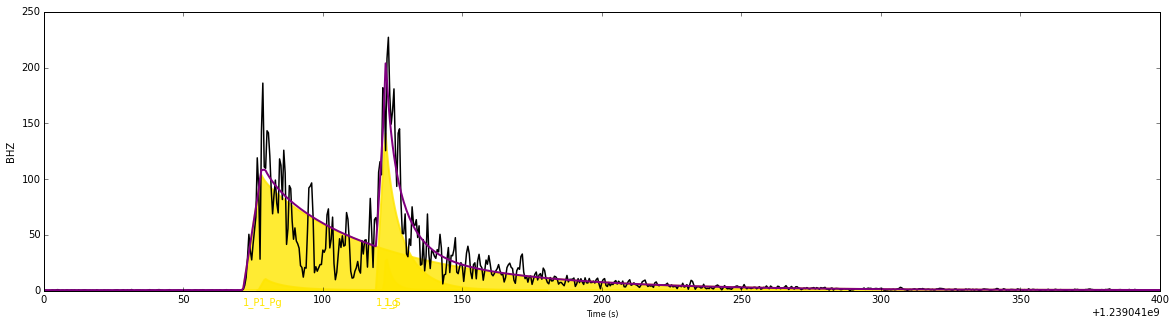

In [31]:
f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(111)
wn.plot(ax)
ax.set_xlim([1239041000.0, 1239041400.0])

array([-1465.29721991])

In [ ]:
ax.set_xlim([123904090.0, 123904590.0])